# Generic sklearn model - MIA (RandomForest)

Download data from https://physionet.org/content/mimic2-iaccd/1.0/ (https://physionet.org/content/mimic2-iaccd/1.0/full_cohort_data.csv to download the full_cohort data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

# Plot functions

In [2]:
def plot_confusion_matrix(name, cm, classes,
                          normalize=False,
                          #title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(str(name)+' - Confusion matrix')
    plt.show()

In [3]:
def plotROC_classifier(clf, X_tmp, y_tmp, X_tmp_test, y_tmp_test, name): #cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    viz = RocCurveDisplay.from_estimator(
            clf,
            X_tmp_test,
            y_tmp_test,
            name="ROC fold {}".format(0),#i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Model "+name,
    )
    ax.legend(loc="lower right")
    plt.show()

In [4]:
def plot_prob_test_train(pred_test, pred_train, name):
    fig, ax = plt.subplots()
    plt.hist(np.array(pred_train).flatten(),  alpha=0.5, bins=20, label='Training Data (Members)',
                histtype='bar', range=(0, 1))
    plt.hist(np.array(pred_test).flatten(),  alpha=0.5, bins=20, label='Test Data (Non-members)',
                histtype='bar', range=(0, 1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))#bbox_to_anchor=(1,0), loc="lower right")
    plt.xlabel('Membership Probability')
    plt.ylabel('Fraction')
    plt.title(name)

# Load data

In [5]:
path = "../../data/mimic2-iaccd/1.0/"
data_path = os.path.join(path, 'full_cohort_data.csv')

In [6]:
X = pd.read_csv(data_path)

# Exploring and processing data

In [7]:
X.shape

(1776, 46)

In [8]:
X.head()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_unit,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
0,1,7.63,13,72.36841,1.0,75.0,29.912791,15.0,9.0,SICU,...,354.0,138.0,4.6,15.0,109.0,41.0,1.6,196.0,39.0,2230.875000
1,0,1.14,1,64.92076,0.0,55.0,20.121312,NaN,5.0,MICU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.000000
2,0,2.86,5,36.50000,0.0,70.0,27.118272,16.0,5.0,MICU,...,295.0,144.0,3.9,17.0,101.0,16.0,0.8,298.0,30.0,2086.800293
3,1,0.58,3,44.49191,0.0,NaN,NaN,21.0,7.0,SICU,...,262.0,139.0,4.2,31.0,100.0,16.0,0.5,146.0,23.0,NaN
4,1,1.75,5,23.74217,1.0,95.2,28.464563,18.0,7.0,SICU,...,22.0,146.0,3.4,19.0,110.0,10.0,1.0,134.0,30.0,2358.244141


In [9]:
X.columns

Index(['aline_flg', 'icu_los_day', 'hospital_los_day', 'age', 'gender_num',
       'weight_first', 'bmi', 'sapsi_first', 'sofa_first', 'service_unit',
       'service_num', 'day_icu_intime', 'day_icu_intime_num',
       'hour_icu_intime', 'hosp_exp_flg', 'icu_exp_flg', 'day_28_flg',
       'mort_day_censored', 'censor_flg', 'sepsis_flg', 'chf_flg', 'afib_flg',
       'renal_flg', 'liver_flg', 'copd_flg', 'cad_flg', 'stroke_flg',
       'mal_flg', 'resp_flg', 'map_1st', 'hr_1st', 'temp_1st', 'spo2_1st',
       'abg_count', 'wbc_first', 'hgb_first', 'platelet_first', 'sodium_first',
       'potassium_first', 'tco2_first', 'chloride_first', 'bun_first',
       'creatinine_first', 'po2_first', 'pco2_first', 'iv_day_1'],
      dtype='object')

## Data especific processing

For data from https://physionet.org/content/mimic2-iaccd/1.0/

In [10]:
#remove columns non-numerical and repetitive or uninformative data for the analysis
col = ['service_unit', 'day_icu_intime', 'hosp_exp_flg','icu_exp_flg', 'day_28_flg'] 
#service_num is the numerical version of service_unit
#day_icu_intime_num is the numerical version of day_icu_intime
# the other columns are to do with death and are somewhat repetitive with censor_flg
X = X.drop(col,axis = 1)
#drop columns with only 1 value
X.drop('sepsis_flg', axis=1, inplace=True)

Generic cleaning up (all data sets)

In [11]:
#drop NA by row
X.dropna(axis=0, inplace=True)
X.shape

(1064, 40)


# Define variable of interest

In [12]:
#Change it for each dataset
var = 'censor_flg'#'aline_flg'#

Obtain labels and remove them from the data

In [13]:
y = X[var]
# Drop the column that contains the labels
X.drop([var], axis=1, inplace=True)

In [14]:
y = np.array(y)
X = np.array(X)
X.shape

(1064, 39)

# Models


write functions here 
1- for the different plots and processing
2- for the different models

## Split train and test data

In [15]:
test_size = 0.2 #Define test size
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=test_size, random_state=58954)

In [23]:
classifiers = {
        'RandomForest':RandomForestClassifier(bootstrap=False), # Added by SR to make sure MIA was working -- this hyp param makes it very MIA susceptible
        'DecisionTree':DecisionTreeClassifier(),
        'GaussianProcess':GaussianProcessClassifier(),
        'MLP':MLPClassifier(),
        'KN':KNeighborsClassifier(),
        'SVM':SVC(kernel='rbf', probability=True)
}

In [24]:
#parameters = 

In [59]:
models = {}
for name,model in classifiers.items():
    models[name] = model.fit(X_train, y_train) # Fixed: this had X, y instead of train data

Model RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       154

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

Confusion matrix, without normalization
[[ 59   0]
 [  0 154]]


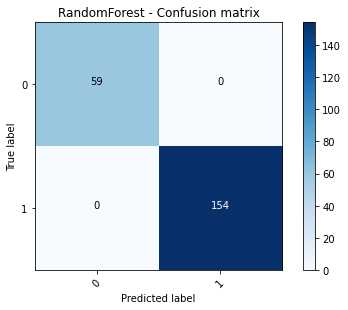

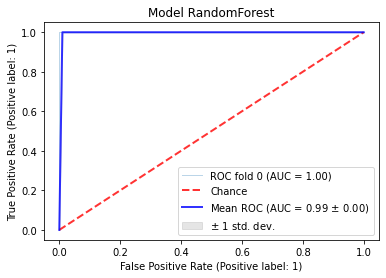

Model DecisionTree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       154

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

Confusion matrix, without normalization
[[ 59   0]
 [  0 154]]


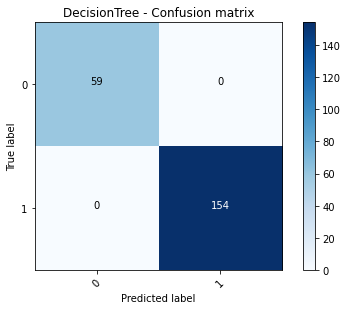

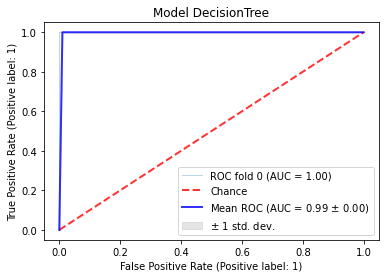

Model GaussianProcess
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        59
           1       1.00      0.01      0.01       154

    accuracy                           0.28       213
   macro avg       0.64      0.50      0.22       213
weighted avg       0.80      0.28      0.13       213

Confusion matrix, without normalization
[[ 59   0]
 [153   1]]


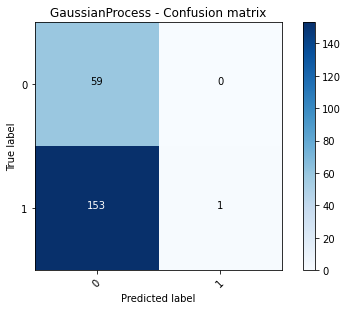

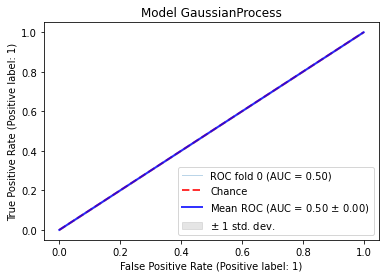

Model MLP
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.98      1.00      0.99       154

    accuracy                           0.99       213
   macro avg       0.99      0.97      0.98       213
weighted avg       0.99      0.99      0.99       213

Confusion matrix, without normalization
[[ 56   3]
 [  0 154]]


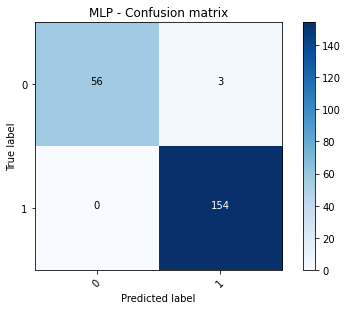

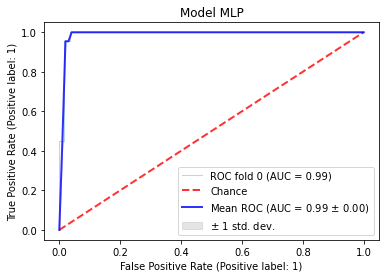

Model KN
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.98      1.00      0.99       154

    accuracy                           0.99       213
   macro avg       0.99      0.97      0.98       213
weighted avg       0.99      0.99      0.99       213

Confusion matrix, without normalization
[[ 56   3]
 [  0 154]]


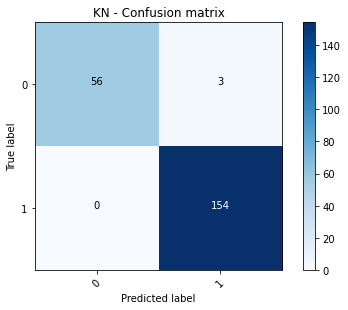

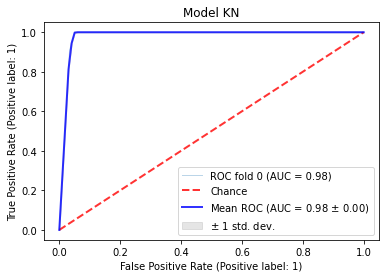

Model SVM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.98      1.00      0.99       154

    accuracy                           0.99       213
   macro avg       0.99      0.97      0.98       213
weighted avg       0.99      0.99      0.99       213

Confusion matrix, without normalization
[[ 56   3]
 [  0 154]]


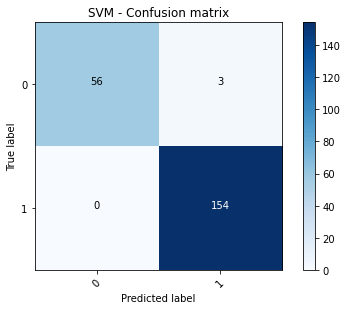

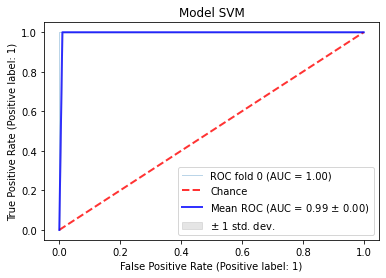

In [60]:
for name, model in models.items():
    print('Model', name)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    plot_confusion_matrix(name, confusion_matrix(y_test, y_pred), range(2))
    plotROC_classifier(model, X, y, X_test, y_test, name)

# Memebership inference attack

Construct a dataset with label of whether or not in the training.

In [62]:
def create_mia_data(clf, xtrain, xtest): # renamed
    # TODO: add docstring
    miX = np.concatenate(
        (
            clf.predict_proba(xtrain), # these were calling predict and not _predict_proba - need probabilities for MIA
            clf.predict_proba(xtest)
        )
    )

    miY = np.concatenate(
        (
        np.ones((len(xtrain), 1), int),
        np.zeros((len(xtest), 1), int)
        )
    ).flatten()
#     miX = miX.reshape(-1, 1) # not needed now we're getting probabilities
    return(miX,miY)

In [63]:
def run_membership_inference_attack(clf_name, model, xtrain, xtest, MIA_classifier, MIA_name):
    print('clf', clf_name)
    miX, miY = create_mia_data(model, xtrain, xtest)
    mi_train_x, mi_test_x, mi_train_y, mi_test_y = train_test_split(miX, miY, test_size=0.2, stratify=miY)
#     mi_train_x = mi_train_x.reshape(-1, 1) # not needed now classifiers returning probabilities
#     mi_test_x = mi_test_x.reshape(-1, 1)
    
    #mia_analysis(model, etc) 
    mi_rf = MIA_classifier
    mi_rf.fit(mi_train_x, mi_train_y)
    
    plotROC_classifier(mi_rf, miX, miY, mi_test_x, mi_test_y, name+" - MIA "+MIA_name)

    mi_pred_y = mi_rf.predict_proba(mi_test_x)
    mi_pred_train_y = mi_rf.predict_proba(mi_train_x)

    plot_prob_test_train(mi_pred_y, mi_pred_train_y, name+" - MIA "+MIA_name)

Split data for MIA into train and test

RandomForest
clf RandomForest


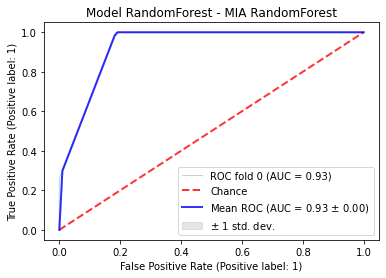

DecisionTree
clf DecisionTree


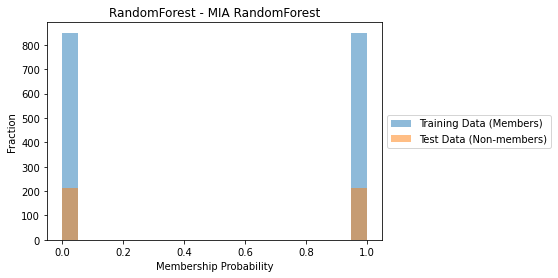

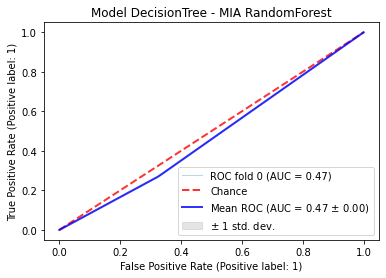

GaussianProcess
clf GaussianProcess


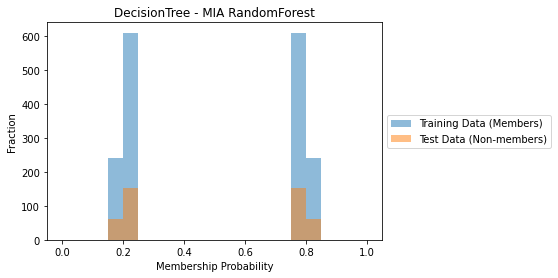

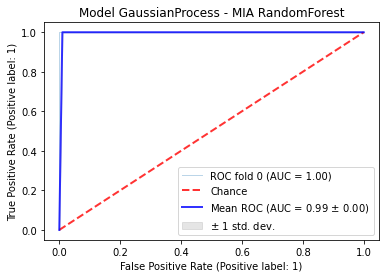

MLP
clf MLP


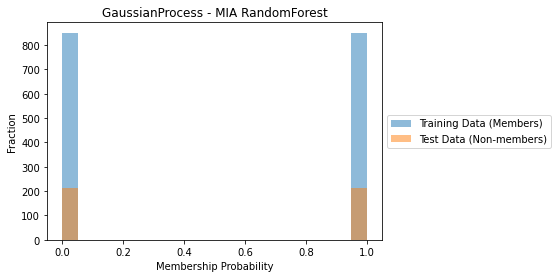

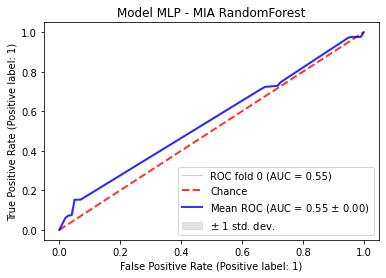

KN
clf KN


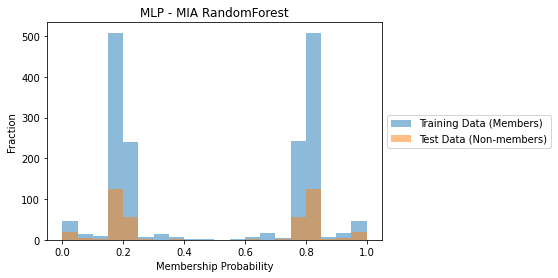

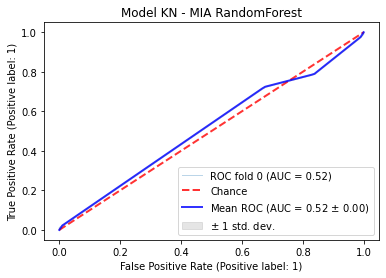

SVM
clf SVM


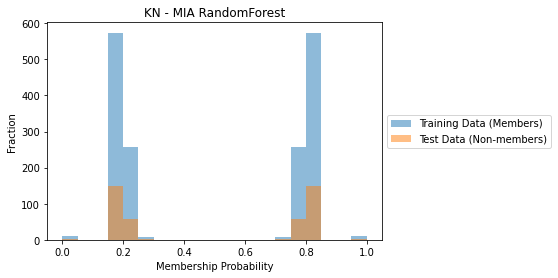

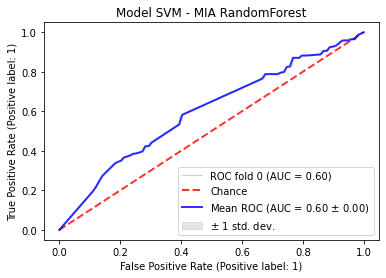

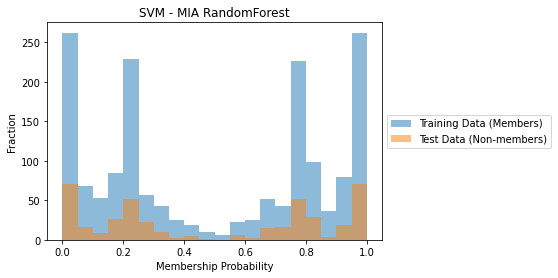

In [64]:
for name,model in models.items(): # they are trained now
    print(name)
    # Note: in the below, I passed a new RandomForestClassifier as the original code would over-write the one we trained above
    run_membership_inference_attack(name, model, X_train, X_test, RandomForestClassifier(), 'RandomForest')